# 2D Data Driven World

## Member Contributions
Neville Wee: Curated and visualized data, wrote model for Task 1. <br>
Nicholas Gandhi: Researched on appropriate metric for Task 1,2. <br>
Janani Sureshkumar: Task 3. <br>
Lim Thian Yew: Task 2. <br>

## Task 1: Data
Number of deaths: https://www.kaggle.com/imdevskp/corona-virus-report?select=country_wise_latest.csv<br>
GDP per capita: https://www.kaggle.com/nitishabharathi/gdp-per-capita-all-countries<br>
Gini Coefficient: https://www.kaggle.com/mannmann2/world-income-inequality-database<br>
Infant Mortality Rate: https://www.kaggle.com/komalkhetlani/infant-mortality<br>
Population Density/Urban Population/Median Age: https://www.kaggle.com/tanuprabhu/population-by-country-2020<br>

We initally thought of a few features we thought would be good predictors for our model. 

## Data Visualisation: Scatterplots
To determine whether these features would be appropriate, we plotted scatterplots of the number of deaths against the features (After removal of outliers).

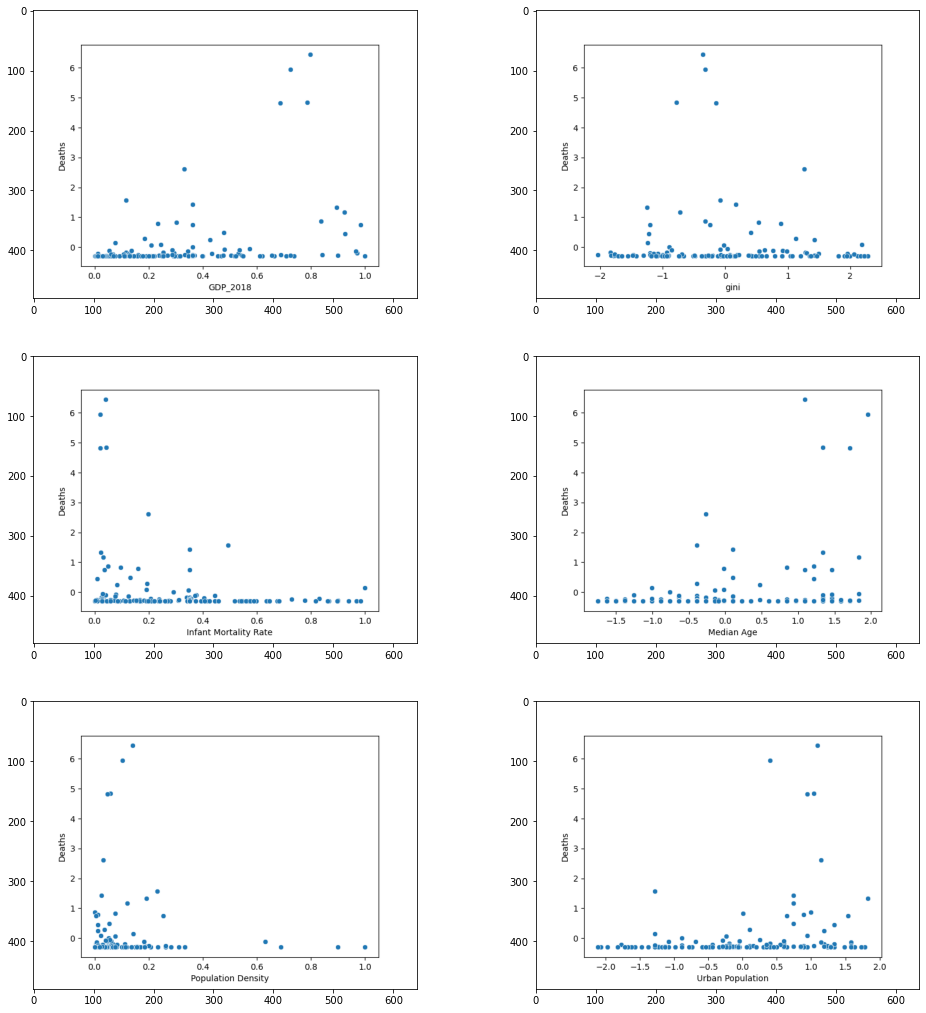

In [186]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# Read images
imgs = ['GDP.png', 'gini.png', 'Infant Mortality.png', 'Median Age.png', 'Pop Density.png', 'Urban Pop.png']
plot = {}
for img in imgs:
    plot[img] = mpimg.imread('plots/'+img)
    
# Display images 
fig, ax = plt.subplots(3,2)
fig.set_figheight(18)
fig.set_figwidth(18)
fig.subplots_adjust(wspace= 0)
n = 0
for x in range(3):
    for y in range(2):
        ax[x,y].imshow(plot[imgs[n]])
        n += 1

## Data Visualisation: Boxplots
We decided to use boxplots to visualize the presence of outliers in the raw data.

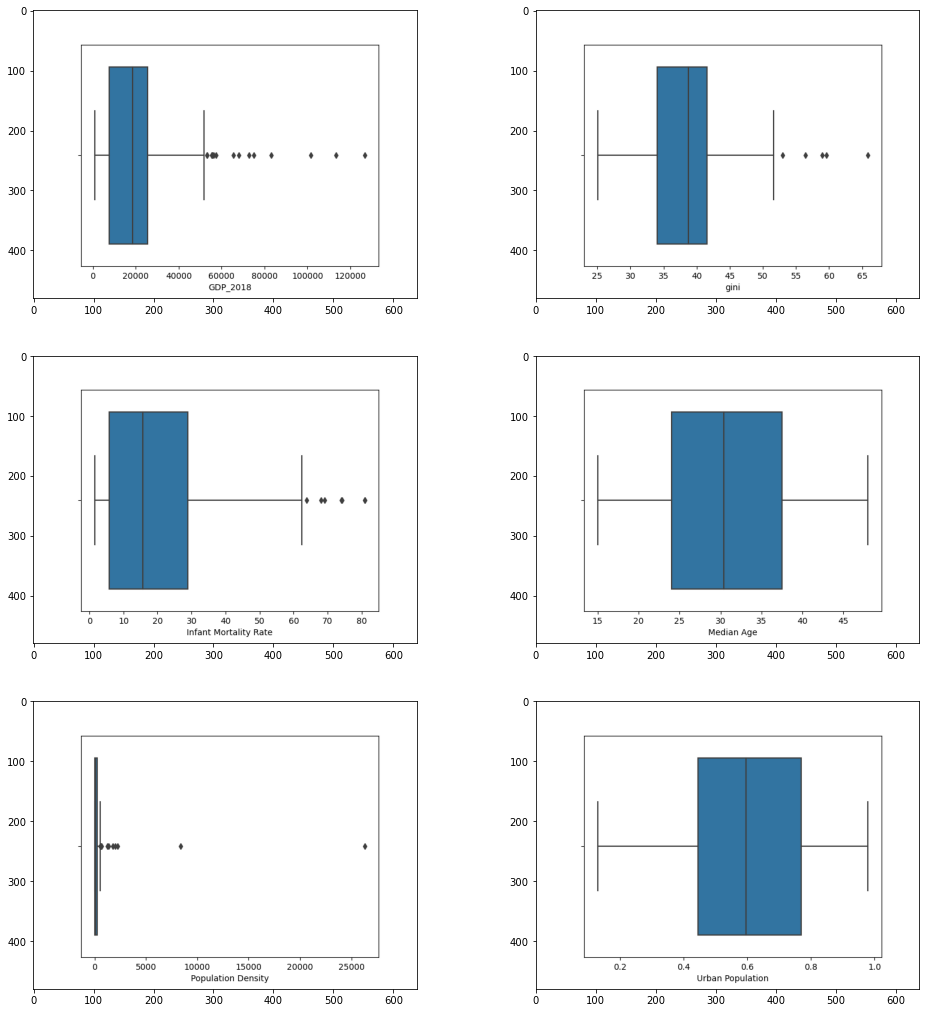

In [187]:
# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# Read images
imgs = ['GDPbox.png', 'gini box.png', 'inf box.png', 'age box.png', 'pop dens box.png', 'urbanpop box.png']
plot = {}
for img in imgs:
    plot[img] = mpimg.imread('plots/'+img)
    
# Display images 
fig, ax = plt.subplots(3,2)
fig.set_figheight(18)
fig.set_figwidth(18)
fig.subplots_adjust(wspace= 0)
n = 0
for x in range(3):
    for y in range(2):
        ax[x,y].imshow(plot[imgs[n]])
        n += 1

## Data Cleaning and Processing
Loading all csv files into separate dataframes.
For each individual dataframe, general cleaning such as renaming columns and indexing columns of interest is done. Furthermore, we only index the countries from these feature dataframes that are in the covid deaths dataframe.

In [188]:
import numpy as np
import pandas as pd

# Load all csv files into separate dataframes
covid = pd.read_csv('datasets/covid_deaths.csv')
gdp = pd.read_csv('datasets/gdp.csv')
gini = pd.read_csv('datasets/wiid_gini.csv', low_memory=False)
inf = pd.read_csv('datasets/infant_mortality_rate.csv', encoding="ISO-8859-1")
age = pd.read_csv('datasets/median_age.csv')
pop = pd.read_csv('datasets/population_by_country_2020.csv')

## Covid Deaths
Summing total deaths from 2020-01-22 to 2020-07-27, by country. <br>

In [189]:
# covid
# sum all covid deaths from 2020-01-22 to 2020-07-27 (by country)
print(covid.columns)
covid = covid.rename(columns={"Country/Region": "Country"})

covid = covid[['Country', 'Confirmed', 'Deaths', 'Recovered']]

covid = covid.groupby(['Country']).sum()
countries = list(covid.index)

Index(['Date', 'Country/Region', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'New cases', 'New deaths', 'New recovered', 'WHO Region'],
      dtype='object')


## GDP

In [190]:
# gdp
gdp = gdp[['Country ', '2018']]  # Index 2018 GDP only
gdp = gdp.rename(columns={"Country ": "Country", '2018' : 'GDP_2018'})
gdp = gdp[gdp['Country'].isin(countries)]

## Gini Coefficient
Since not all countries have recent gini coefficient readings, with some countries lacking readings from even before 2015, we set a cutoff to index all countries with values from after 2010.

In [191]:
# extract cols below from wiid_gini.csv
gini_year_cutoff = 2010
cols = ['id', 'country', 'year', ' gini ']
gini = gini[cols]
all_countries = pd.DataFrame(gini['country'].unique())
countries_gini = pd.DataFrame(gini[gini['year'] >= gini_year_cutoff]['country'].unique())
missing_countries = pd.concat([all_countries, countries_gini]).drop_duplicates(keep=False)
gini = gini[gini['year'] >= gini_year_cutoff]
gini = gini.groupby(['country']).mean()
gini = gini[gini.index.isin(countries)]
gini = pd.DataFrame(gini[' gini '])
gini = gini.rename(columns={' gini ' : 'gini'})

## Infant Mortality

In [192]:
# infant mortality
inf = inf[(inf['Year'] == 2019) & (inf['Gender']=='Total')]
inf = inf[inf['Country'].isin(countries)]
inf = inf[['Country', 'Infant Mortality Rate']]

## Population

In [193]:
# population
pop = pop[['Country (or dependency)', 'Density (P/Km²)', 'Urban Pop %', 'Med. Age']]
pop = pop.rename(columns={"Country (or dependency)": "Country", 'Density (P/Km²)':'Population Density',
                            'Urban Pop %':'Urban Population', 'Med. Age':'Median Age'})
pop = pop[pop['Country'].isin(countries)]
pop = pop.sort_values(by=['Country'])

In [194]:
# Combine all dataframes into single dataframe
df = covid.merge(gdp, how='left', left_on='Country', right_on='Country')
df = df.merge(gini, how='left', left_on='Country', right_index=True)
df = df.merge(inf, how='left', left_on='Country', right_on='Country')
df = df.merge(pop, how='left', left_on='Country', right_on='Country')

## Urban Population/Median Age
We replace the "N.A." string values with np.Nan, and convert the string values in Urban Population to a float type (From "25%" to 0.25).

In [195]:
# Fix Urban Population Column
# Replace N.A. with NaN
df['Urban Population'] = df['Urban Population'].replace('N.A.', np.NaN)
df['Median Age'] = df['Median Age'].replace('N.A.', np.NaN)
# Convert 25 % to 0.25
df.loc[df['Urban Population'].notna(), 'Urban Population'] = df[df['Urban Population'].notna()]['Urban Population'].apply(lambda x: int(x[:-2])/100)
df.to_csv('data.csv')
# Convert Median column value types to float from str
df['Median Age'] = pd.to_numeric(df['Median Age'])
print(df)

                Country  Confirmed  Deaths  Recovered      GDP_2018  \
0           Afghanistan    1936390   49098     798240   1955.006208   
1               Albania     196702    5708     118877  13364.155400   
2               Algeria    1179755   77972     755897  15481.787620   
3               Andorra      94404    5423      69074           NaN   
4                Angola      22662    1078       6573   6452.355165   
..                  ...        ...     ...        ...           ...   
182  West Bank and Gaza     233461    1370      61124   5157.568578   
183      Western Sahara        901      63        648           NaN   
184               Yemen      67180   17707      23779           NaN   
185              Zambia     129421    2643      83611   4223.906936   
186            Zimbabwe      50794     881      12207   3029.793005   

          gini  Infant Mortality Rate  Population Density Urban Population  \
0    32.000000              46.512825                60.0            

In [196]:
print(df['Median Age'][0])
print(type(df['Median Age'][0]))

18.0
<class 'numpy.float64'>


## Imputation

In order to deal with missing values, we implemented a few statistical methods of filling in the data, including filling in all NaN values with mean, median, mode or a constant. As of now, we will arbitrarily pick impute_mean as our method, and cross-validate the other methods later on to see which one gives us the best result for our model.

In [197]:
def impute_mean(df, feature):
    mean = df[feature].mean()
    df[feature] = df[feature].fillna(mean)

def impute_mode(df, feature):
    mode = df[feature].mode()
    df[feature] = df[feature].fillna(mode)

def impute_median(df, feature):
    median = df[feature].median()
    df[feature] = df[feature].fillna(median)

def impute_constant(df, feature, const=0):
    df[feature] = df[feature].fillna(const)

## Data Scaling
As we have learnt in our cohorts, there is a need to normalize our features such that our model is not biased towards certain features over others. We have decided to implement normalization for data that does not follow a Gaussian distribution and standardization for data that does.

In [198]:
def normalize(df, feature):
    min = df[feature].min()
    max = df[feature].max()
    df[feature] = df[feature].apply(lambda x: (x-min)/(max-min))

def standardize(df, feature):
    mean = df[feature].mean()
    std = df[feature].std()
    df[feature] = df[feature].apply(lambda x: (x-mean)/std)

## Data Distribution Visualisation?

## Final Pipeline
We will now apply our imputation and normalization methods to the data we have combined into a single DataFrame earlier.

In [199]:
# Imputation (Impute mean first, cross validate other methods later)
features = ['GDP_2018', 'gini', 'Infant Mortality Rate', 'Population Density', 'Urban Population', 'Median Age']
for feature in features:
    impute_mean(df, feature)
# Scale Features ()
normally_distributed = ['gini', 'Urban Population', 'Median Age']
not_normally_distributed = ['GDP_2018', 'Infant Mortality Rate', 'Population Density']
for feature in normally_distributed:
    standardize(df, feature)
for feature in not_normally_distributed:
    normalize(df, feature)

# Scale Labels (standardize)
standardize(df, 'Deaths')

# Save new DataFrame to a csv
df.to_csv('data_processed.csv', index=False)

In [200]:
print(df)

                Country  Confirmed    Deaths  Recovered  GDP_2018  \
0           Afghanistan    1936390 -0.183324     798240  0.009598   
1               Albania     196702 -0.226813     118877  0.100036   
2               Algeria    1179755 -0.154384     755897  0.116822   
3               Andorra      94404 -0.227099      69074  0.164993   
4                Angola      22662 -0.231454       6573  0.045248   
..                  ...        ...       ...        ...       ...   
182  West Bank and Gaza     233461 -0.231161      61124  0.034984   
183      Western Sahara        901 -0.232471        648  0.164993   
184               Yemen      67180 -0.214787      23779  0.164993   
185              Zambia     129421 -0.229885      83611  0.027583   
186            Zimbabwe      50794 -0.231651      12207  0.018118   

             gini  Infant Mortality Rate  Population Density  \
0   -1.009881e+00               0.566213            0.002278   
1   -9.097726e-01               0.089562   

## Task 1: Model
## Discussion on features
While scatterplots are useful in visualizing a possible relationship between features and the number of deaths, a good metric would be more appropriate in choosing which features to include or remove in the model. We decided to utilise Pearson's Correlation Coefficient in order to determine the level of linear correlation between our features and label.



## Pearson Correlation Coefficient Formula

$$r = \frac{\Sigma(x_i-\bar{x})(y_i-\bar{y})}{\sqrt{\Sigma(x_i-\bar{x})^2(y_i-\bar{y})^2}}$$


## Pearson Correlation Coefficient Implementation

In [201]:
def pearsons_r(df, feature, label):
    x = df[feature].to_numpy()
    y = df[label].to_numpy()
    num = ((x - x.mean())*(y - y.mean())).sum()
    x1 = ((x - x.mean())**2).sum()
    y1 = ((y - y.mean())**2).sum()
    den = (x1*y1)**0.5
    return num/den

Iterating through the features to calculate the respective r values.

In [202]:
df = pd.read_csv('data_processed.csv')
features = ['GDP_2018', 'gini', 'Infant Mortality Rate', 'Population Density', 'Urban Population', 'Median Age']

for feature in features:
    print(feature, ':', pearsons_r(df, feature, 'Deaths'))

GDP_2018 : 0.10178419029463641
gini : 0.009142921481868172
Infant Mortality Rate : -0.11109483412568627
Population Density : -0.01824510044210233
Urban Population : 0.14046752685915423
Median Age : 0.15956387714810863


Since the r values for our features aren't looking too great, we can look to a change of features in order to improve our model's accuracy later on.

## Discussion on building model

Our model closely follows what we have done in class, implementing multiple linear regression with gradient descent.

In [203]:
def normalize_z(df):
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    return (df - mean) / std

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def compute_cost(X, y, beta):
    m = len(y)
    # print('X:', X)
    # print('beta', beta)
    J = (1/(2*m))*(np.square(np.matmul(X, beta) - y)).sum(axis=0)
    return J

def prepare_feature(df_feature):
    m, n = df_feature.shape
    feature_np = df_feature.to_numpy()
    feature_np = feature_np.reshape(m,n)
    feature_np = np.concatenate((np.ones((m,1)), feature_np), axis=1)
    return feature_np

def prepare_target(df_target):
    target_np = df_target.to_numpy()
    return target_np

def gradient_descent(X, y, beta, alpha, num_iters):
    m = len(y)
    J_storage = []
    for iter in range(num_iters):
        J_storage.append(compute_cost(X, y, beta))
        hx = np.matmul(X, beta)
        beta = beta - alpha*(1/m)*(np.matmul(X.T, hx - y))
    return beta, J_storage

def predict_norm(X, beta):
    return np.matmul(X, beta)


def predict(df_feature, beta):
    df_feature = normalize_z(df_feature)
    df_feature = prepare_feature(df_feature)
    return predict_norm(df_feature, beta)

def mean_squared_error(target, pred):
    n = len(target)
    mse = (1/n)*(np.square(target-pred)).sum(axis=0)
    return mse

## K-folds Cross Validation

In order to better evaluate the effectiveness of our model, we decided to implement k-folds cross validation, which gives a less biased estimate of our model's skill as opposed to a regular train test split.

In [204]:
import statistics

def cross_val_score(df_feature, df_target, beta, alpha, num_iters, random_state=100, cv=5):
    index = df_feature.index
    index = list(index)

    # Shuffles the indexes
    np.random.RandomState(random_state).shuffle(index)

    # Split indexes into cv parts
    folds = partition(index, cv)
    r2_scores = []
    mse_scores = []

    # Iterates through cv parts, each time using each part as test set/rest as train set
    # records r2/mse value and adds to scores
    for fold in folds:
        # print('fold:', fold)
        # basically train test split here
        df_feature_train = df_feature[~df_feature.index.isin(fold)]
        df_target_train = df_target[~df_target.index.isin(fold)]
        df_feature_test = df_feature.iloc[fold, :]
        df_target_test = df_target.iloc[fold, :]

        X = df_feature_train
        X = prepare_feature(X)
        y = prepare_target(df_target_train)

        beta, J_storage = gradient_descent(X, y, beta, alpha, num_iters)
        print('Cost:', J_storage[0] - J_storage[-1])
        pred = predict(df_feature_test, beta)
        target = prepare_target(df_target_test)
        mse = mean_squared_error(target, pred).item(0)

        mse_scores.append(mse)
    return statistics.mean(mse_scores)


# Splits list into n equal parts
def partition(lst, n):
    division = len(lst) / n
    return [lst[round(division * i):round(division * (i + 1))] for i in range(n)]

## Task 1: Model Evaluation

With regards to the appropriate metric, we deliberated between $r^2$, MSE (Mean Squared Error) and RMSE (Root Mean Squared Error).<br>

$$r^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$


Although $r^2$ is a good measure for how well a model fits dependent variables, this metric does not take into account the overfitting problem. This is because if the regression model contains too many independent variables, the model becomes too complicated. Hence while the model may fit the training data very well, it will perform poorly on the testing data. <br>

$$MSE = \frac{1}{n}\Sigma_{i=1}^n(y^i - \hat{y}^i)^2$$

Therefore, we believe that Mean Squared Error (MSE) is a better metric since MSE is derived by summing the square of the prediction error (real output minus the predicted output) and then dividing it by the number of data points. This yields an absolute number that represents how much the predicted results differ from the actual value. <br>

$$RMSE = \sqrt{MSE}$$

Root Mean Square Error (RMSE) is the square root of MSE. RMSE may be preferred because sometimes the MSE value may be too large, and thus, can be difficult to compare. Outliers have a significant impact on the RMSE and hence should be removed from the data. 
One more thing to note is that RMSE is based on the premise that errors are unbiased and have a normal distribution.<br>

**Resources consulted**:

## Results of metric on test data set

In [205]:
features = ['GDP_2018', 'gini', 'Infant Mortality Rate', 'Population Density', 'Urban Population', 'Median Age']
no_features = len(features)

df_features, df_target = get_features_targets(df, features, ['Deaths'])

mse = cross_val_score(df_features, df_target, beta=np.zeros((no_features+1, 1)),
                              alpha=0.1, num_iters=10000, random_state=100, cv=10)
print(mse)

Cost: [0.02079107]
Cost: [0.00234749]
Cost: [0.00100298]
Cost: [0.00045927]
Cost: [0.00272486]
Cost: [0.00144257]
Cost: [0.00143412]
Cost: [0.00065351]
Cost: [0.00228301]
Cost: [0.0009545]
1.25981630799163


## Task 1: Improvements (Iterations)

Since all features and labels have been normalized/standardized, intuitively, a mse of __ is quite significant. Hence, as we mentioned earlier, there are steps we can take in attempting to improve the accuracy of our model. These include a removal of outliers, exclusion of certain features, and dunno yet.